<a href="https://colab.research.google.com/github/kecosz/rELA/blob/main/rELA0_52_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tutorial for rELA 0.52
### Notes:
### 0.52
The typical value of *qth* for *runSA* has changed due to a change in the method of calculating the stopping criterion

### 0.46
*Formatting* now works even if "basemetadata" is not given. Also, in *Formatting*, the parameter for specifying whether normalization is performed changed from "normalizeq" to "normalize".

## Setup

In [1]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

## rpy2 version specification
### Required to successfully execute "%load_ext rpy2.ipython" as of 2023/1
!pip install rpy2==3.5.1
#!pip install --upgrade ipykernel
%load_ext rpy2.ipython

###The following codes is just for not showing rpy2 messages related to R package installation on google colab
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
import logging
rpy2_logger.setLevel(logging.ERROR)   # will display errors, but not warnings

## Doanload rELA package
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314933 sha256=0755f80ed1f6909f6d8beefc9588b90b20fc07660325f23437b372f0b872805c
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2
  Attempting uninstall: rpy2
    Found existing installation: rpy2 3.4.2
    Uninstalling rpy2-3.4.2:
      Successfully uninstalled rpy2-3.4.2
rm: cannot remove 'rELA': No such file or directory
Cloning into 'rELA'...
remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 469 (delta 133), reused 157 (delta 65), pack-reused 175
Receiving objects: 100% (469/469), 6.89 MiB | 16.23 MiB/s, done.
Resolving deltas: 100% (197/197), done.


In [2]:
%%R
# [for Google Colab]
# from v0.50, Due to errors in installing igraph and tidygraph
#system("add-apt-repository -y ppa:marutter/rrutter4.0")
#system("add-apt-repository -y ppa:c2d4u.team/c2d4u4.0+")
#system("add-apt-repository ppa:cran/v8")
#system("apt-get update")
#system("apt-get install libnode-dev")
#system("apt-get install r-cran-igraph r-cran-tidygraph")

NULL


In [3]:
%%R
## package instllation
install.packages("Rcpp")
install.packages("RcppArmadillo")
install.packages("doParallel")
install.packages('tidyverse')
install.packages('gsubfn')
install.packages('zoo')
install.packages('plyr')
install.packages('gtools')
install.packages('ggsci')
install.packages('igraph')
install.packages('tidygraph')
install.packages('RColorBrewer')
install.packages("stringdist")
install.packages("purrr")
install.packages("plot3D")
library("Rcpp")
library("RcppArmadillo")
library("doParallel")
library('tidyverse')
library('gsubfn')
library('zoo')
library('plyr')
library('gtools')
library('ggsci')
library('igraph')
library('tidygraph')
library('RColorBrewer')
library("stringdist")
library("purrr")
library("plot3D")


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ purrr::accumulate() masks foreach::accumulate()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::when()       masks foreach::when()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [24]:
%%R
# install rELA package
install.packages("rELA/rELA.v0.52.tar.gz")
library("rELA")

In [23]:
%%R
remove.packages("rELA")

In [6]:
!rm -r rELA
!git clone https://github.com/kecosz/rELA.git

Cloning into 'rELA'...
remote: Enumerating objects: 469, done.
remote: Counting objects: 100% (294/294), done.
remote: Compressing objects: 100% (229/229), done.
remote: Total 469 (delta 133), reused 157 (delta 65), pack-reused 175
Receiving objects: 100% (469/469), 6.89 MiB | 21.46 MiB/s, done.
Resolving deltas: 100% (197/197), done.


## Energy Landscape Analysis

### Download data

In [26]:
%%R
# Specify the path for your own data in the code below, if necessary.
baseabtable <- read.csv('rELA/data/abundance_table.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")
basemetadata <- read.csv('rELA/data/sample_metadata.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")

In [27]:
%%R
head(basemetadata, 7)

         factor.1   factor.2
sample.1    -0.92 2.79692115
sample.2     0.34 2.14701252
sample.3    -0.92 1.60611363
sample.4    -0.24 0.58476465
sample.5     0.40 1.73161379
sample.6    -0.82 2.95971753
sample.7     0.36 0.07787331


In [28]:
%%R
# To group species with the same presence/absence pattern into one group,
#set grouping to 1 and specify a number between 0 and 1 for grouping_th.
# If 0, only species with the same presence/absence pattern will be grouped together.
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata=NULL, normalize=1, parameters=c(0.01, 0.01, 0.99), grouping=1, grouping_th=0.)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


### Parameter fitting

In [29]:
%%R
#runSA: ocmatrix, env (environmental parameters; with>SA / without>fullSA), qth (threshold for stopping computation), rep (number of fitting processes to compute mean parameter value), threads (number of parallel threads)
sa <- runSA(ocmat=as.matrix(ocmat), qth=10^-2, rep=256, threads=1)


Start parameter fitting:
................................................................................................................................................................................................................................................................SA: elapsed time 34.39 sec



In [30]:
%%R
list[he,je,ge,hge] <- sa2params(sa)

In [31]:
%%R
he

 species.12  species.16   species.7   species.5   species.2  species.10 
-0.72372237 -0.47470103 -0.34667348 -0.43887270 -0.82122119 -0.95645622 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.21320152 -0.51255594 -0.16292678 -0.05068014  1.26522868  0.15212779 
  species.3  species.13   species.1   species.9 
 0.15514502  0.01723668  0.95241668  0.89164345 


In [32]:
%%R
hge

 species.12  species.16   species.7   species.5   species.2  species.10 
-0.72372237 -0.47470103 -0.34667348 -0.43887270 -0.82122119 -0.95645622 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.21320152 -0.51255594 -0.16292678 -0.05068014  1.26522868  0.15212779 
  species.3  species.13   species.1   species.9 
 0.15514502  0.01723668  0.95241668  0.89164345 


### Analysis and visualization of energy landscape
#### ELA function

In [33]:
%%R
ela <- ELA(sa, env=NULL,
                SS.itr=20000, FindingTip.itr=10000, # <- the number of steps for finding stable states and tipping points (basically no need to change)
                threads=2, reporting=TRUE)

Start ELA:
6 stable states were found.
Checking 15 tipping points.
converting...
ELA: elapsed time 1.49 sec


In [34]:
%%R
elap <- ELPruning(ela, th=0.2)

Start pruning:
*.....
ELPruning: elapsed time 0.39 sec


*ATTENTION*  
The return value of ELPruning is a list consisting of two elements, the first of which takes the same form as ELA, and the second of which indicates the correspondence between the stable states before and after pruning.

In [35]:
%%R
list[stablestates, stablen, tippingpoints, tippingen] <- elap[[1]]

Stable states

In [36]:
%%R
stablestates

[1] "09x" "EWB" "1uV"


Convert an integer representing a stable state (ssid) to a binary vector

In [37]:
%%R
# ssid -> binary vector
bin = as.list(lapply(stablestates, function(x){id2bin(x, ncol(ocmat))}))
names(bin) <- stablestates
bin

$`09x`
 [1] 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1

$EWB
 [1] 1 1 1 0 1 0 0 0 0 0 0 0 1 0 1 1

$`1uV`
 [1] 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 1



Convert a binary vector to a ssid

In [38]:
%%R
# binary vector -> ssid
as.vector(sapply(bin, bin2id))

[1] "09x" "EWB" "1uV"


Table of SSID, Energy, Community composition

In [39]:
%%R
sstable(elap[[1]]) # or sstable(ela)

   ID            Energy species.12 species.16 species.7 species.5 species.2
1 09x -21.5026336486246          0          0         0         0         0
2 EWB -21.4032921146701          1          1         1         0         1
3 1uV  -18.754778779488          0          0         0         1         1
  species.10 species.8 species.11 species.15 species.6 species.4 species.14
1          0         1          0          0         1         1          1
2          0         0          0          0         0         0          0
3          1         1          0          0         0         0          1
  species.3 species.13 species.1 species.9
1         1          0         1         1
2         1          0         1         1
3         1          1         1         1


Export the table to Google Drive in CSV format

In [40]:
%%R
write.csv(x = sstable, file="drive/MyDrive/colab_export/sstable.csv") # "sstable.csv" is saved in "colab_export" folder of your Google Drive.

ID and energy of tipping points

In [41]:
%%R
as.data.frame(tippingpoints)

   X1  X2  X3
1 Inf 4eB 0O/
2 Inf Inf 4eB
3 Inf Inf Inf


In [42]:
%%R
as.data.frame(tippingen)

   X1        X2        X3
1 Inf -13.24318 -16.56168
2 Inf       Inf -13.24318
3 Inf       Inf       Inf


Table of TPID, SSID1, SSID2, Energy, Community composition

In [43]:
%%R
tptable(elap[[1]])

   TP SS1 SS2            Energy species.12 species.16 species.7 species.5
1 4eB EWB 09x -13.2431803110843          0          1         0         0
2 0O/ 1uV 09x -16.5616750719837          0          0         0         0
3 4eB 1uV EWB -13.2431803110843          0          1         0         0
  species.2 species.10 species.8 species.11 species.15 species.6 species.4
1         1          0         1          0          0         0         0
2         0          1         1          0          0         0         1
3         1          0         1          0          0         0         0
  species.14 species.3 species.13 species.1 species.9
1          0         1          0         1         1
2          1         1          1         1         1
3          0         1          0         1         1


Energy of any community composition


In [44]:
%%R
cEnergy(ocmat[1,], he, je)

[1] -3.185784


Find the stable state for a community composition

In [45]:
%%R
Bi(ocmat[1,], he, je)

[[1]]
[1] "01t"

[[2]]
[1] -11.58542



### Principal component analysis  
Observed community compositions plotted on a PC1,2 plane and color-coded by their stable states

NULL


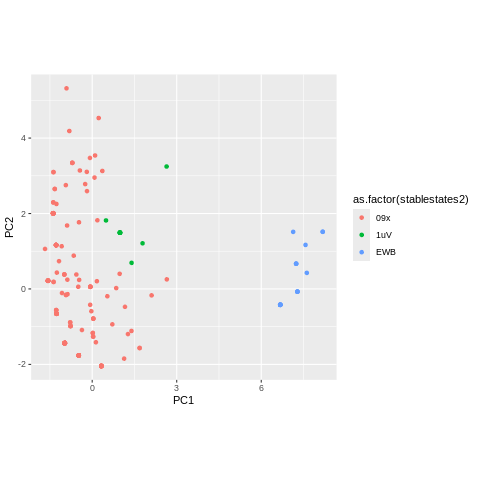

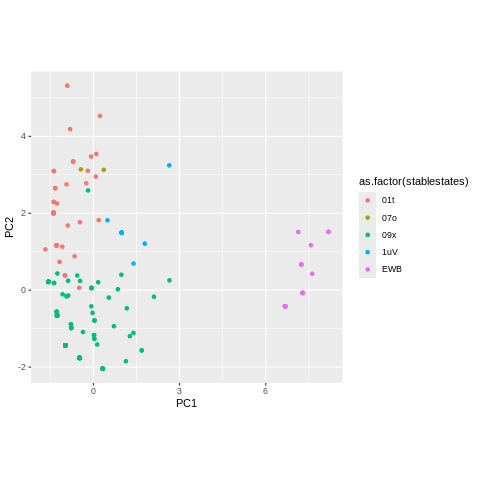

In [46]:
%%R
PCplot(ocmat, sa, ssrep=elap[[2]])
PCplot(ocmat, sa, ssrep=elap[[2]], pruned=FALSE)

Disconnectivity graph


NULL


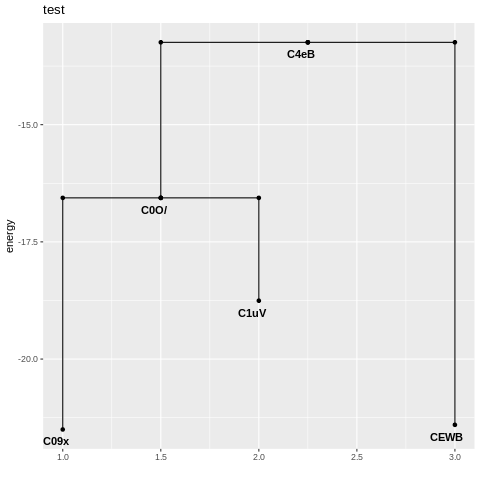

In [47]:
%%R
showDG(elap[[1]], ocmat, "test")

### Visualization of species' interaction

NULL


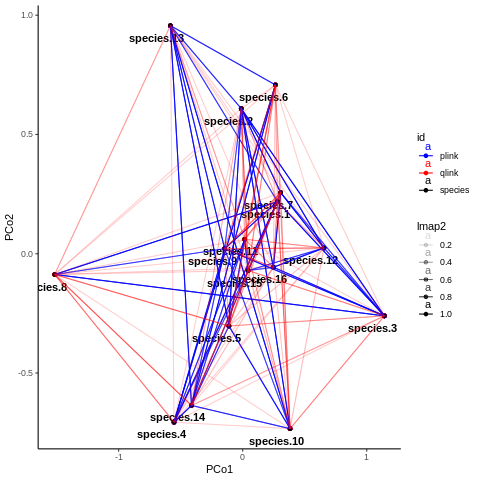

In [48]:
%%R
showIntrGraph(elap[[1]], sa, th=0.01, # <- Threshold for links to be displayed
              annot_adj=c(0.75, 2.00))

### Energy landscape analysis with environmental gradients

In [49]:
%%R
baseabtable <- read.csv('rELA/data/abundance_table.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")
basemetadata <- read.csv('rELA/data/sample_metadata.csv', sep=',', fileEncoding='utf-8') %>%
  column_to_rownames(., var = "X")

In [50]:
%%R
list[ocmat, abmat, enmat, samplelabel, specieslabel, factorlabel] <-
  Formatting(baseabtable, basemetadata, 1, c(0.01, 0.01, 0.99), 1, 0)

Processed 256 samples.
Relative abundance threshold = 0.01 
Occurrence threshold (lower) = 0.01 
Occurrence threshold (upper) = 0.99 
0  groups were found.
Selected  16  out of  16 species.


In [51]:
# Parameter fitting including environmental parameters
%%R
sa <- runSA(ocmat=as.matrix(ocmat), enmat=as.matrix(enmat), qth=10^-2, rep=256, threads=1)

Start parameter fitting
................................................................................................................................................................................................................................................................SA: elapsed time 30.76 sec



In [52]:
%%R
gela <- GradELA(sa=sa, eid="factor.1", # Specify the label or position of an environmental factor
  enmat=enmat, env=NULL, range=NULL, steps=32, th=0.05, threads=2) #[[1]]: return value of ELA function for each step, [[2]]: value of environmental factor for each step, [[3]]: specified environmental factor

env not specified, the mean of enmat is used
processing(32) |================================|
Elapsed time 35.73 sec


NULL


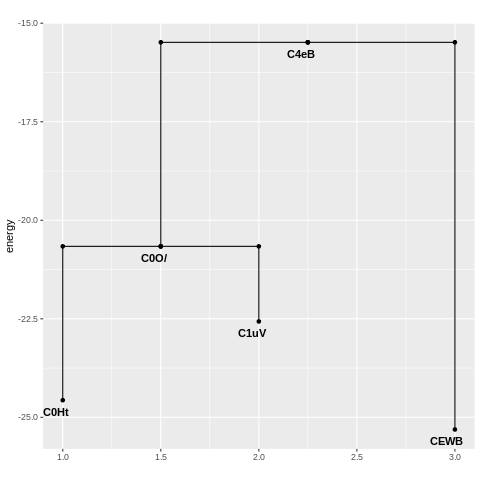

In [53]:
# Disconnectivity graph
%%R
showDG(gela[[1]][[1]][[1]], ocmat)

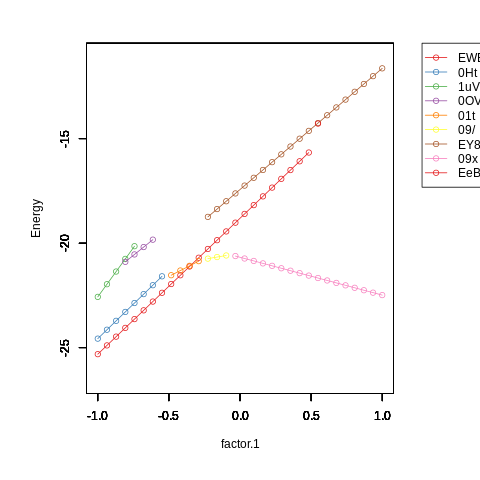

In [54]:
# Stable state diagram
%%R
showSSD(gela)

In [55]:
%%R
gstates <- foreach(x=gela[[1]], .combine='c') %do% {
    x[[1]][[1]]}
unique(gstates)

[1] "EWB" "0Ht" "1uV" "0OV" "01t" "09/" "EY8" "09x" "EeB"


#### GradELA 3D plot

In [56]:
%%R
gelsobj <- GELSObj(gela, sa, threads=2)

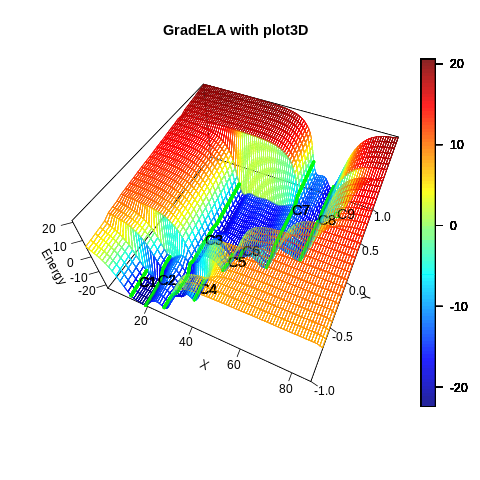

In [57]:
%%R
showGELA3D(gelsobj)

## Stability

In [58]:
%%R
stb <- Stability(sa, ocmat, enmat=NULL, threads=2)
head(stb, 5)

Start Stability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
Stability: elapsed time 9.26 sec

           energy.gap ss.entropy  e.realize  e.stable state.id stable.state.id
sample.1   10.3784792  0.0000000  -1.521708 -11.90019      07/             09x
sample.10   1.2276581  0.8385801 -18.541734 -19.76939      08/             09x
sample.100  5.8007233  0.2778396 -13.171655 -18.97238      1uF             09x
sample.101  0.4463552  0.0000000 -20.342132 -20.78849      09t             09x
sample.102  0.7793947  0.0000000 -19.898820 -20.67822      01t             09x


In [59]:
%%R
Stability <- function(sa, ocmat, enmat=NULL, threads=1, reporting=TRUE){
  if(reporting){cat('Start Stability:\n')}
  start <- proc.time()[3]
  sadim <- dim(sa[[1]])
  if(reporting && sadim[2] > sadim[1]+1 && is.null(enmat)){cat("sa obtained with enmat, but enmat is not given.\nassigned a zero vector as the environmental condition for all data points.\n")}
  if(reporting && sadim[2] == sadim[1]+1 && !is.null(enmat)){cat("sa obtained without enmat, but enmat is given. enmat is omitted.\n")}

  no <- ncol(ocmat)
  if(!is.null(enmat) && sadim[2] > sadim[1]+1){
      ne <- ncol(enmat)

      if(threads>1){cluster = makeCluster(threads)
      clusterCall(cluster, function(x) .libPaths(x), .libPaths())
      registerDoParallel(cluster)
      on.exit(stopCluster(cluster))}

      if(threads>1){stab <- foreach(x=t(cbind(as.data.frame(ocmat), enmat)), .combine="rbind", .packages=c("rELA", "tidyverse", "foreach")) %dopar%{
      env <- x[(no+1):(no+ne)]
      sa2p <- sa2params(sa, env)
      je <- sa2p[[2]]
      hge <- sa2p[[4]]
      state <- bin2id(x[1:no])
      # basin #
      bi <- Bi(x[1:no], hge, je)
      ssid <- bi[[1]]
      e.stable <- bi[[2]]
      # energy gap #
      e.realize <- cEnergy(x[1:no], hge, je)
      energy.gap <- as.numeric(e.realize - e.stable)
      # ss entropy #
      minsets <- SSestimate(hge, je, itr = 10000)
      minsets <- unique(minsets[,-ncol(minsets)])
      sse <- SSentropy(
          as.matrix(t(as.data.frame(x[1:no]))),
                       ss=minsets, alpha= hge, beta=je, seitr=1000, convTime=10000)
      ss.entropy <- sse[,1]
      cbind(as.data.frame(t(as.matrix(c(energy.gap, ss.entropy, e.realize, e.stable)))),
            as.data.frame(t(as.matrix(c(state, ssid))))) %>% "colnames<-" (c("energy.gap", "ss.entropy","e.realize","e.stable","state.id","stable.state.id"))
      }}else{
      stab <- foreach(x=t(cbind(as.data.frame(ocmat), enmat)), .combine="rbind") %do% {
      env <- x[(no+1):(no+ne)]
      sa2p <- sa2params(sa, env)
      je <- sa2p[[2]]
      hge <- sa2p[[4]]
      state <- bin2id(x[1:no])
      # basin #
      bi <- Bi(x[1:no], hge, je)
      ssid <- bi[[1]]
      e.stable <- bi[[2]]
      # energy gap #
      e.realize <- cEnergy(x[1:no], hge, je)
      energy.gap <- as.numeric(e.realize - e.stable)
      # ss entropy #
      minsets <- SSestimate(hge, je, itr = 10000)
      minsets <- unique(minsets[,-ncol(minsets)])
      sse <- SSentropy(
          as.matrix(t(as.data.frame(x[1:no]))),
                       ss=minsets, alpha= hge, beta=je, seitr=1000, convTime=10000)
      ss.entropy <- sse[,1]
      cbind(as.data.frame(t(as.matrix(c(energy.gap, ss.entropy, e.realize, e.stable)))),
            as.data.frame(t(as.matrix(c(state, ssid))))) %>% "colnames<-" (c("energy.gap", "ss.entropy","e.realize","e.stable","state.id","stable.state.id"))
      }}
     rownames(stab) <- rownames(ocmat)
     }else{
      sa2p <- sa2params(sa)
      je <- sa2p[[2]]
      hge <- sa2p[[4]]
      sampleSS <- t(apply(ocmat, 1, SteepestDescent, alpha=hge, beta=je))
      sse <- SSentropy(ocmat, ss=unique(sampleSS[,-ncol(sampleSS)]), alpha= hge, beta=je, seitr=1000, convTime=10000)
      if(sum(sse[,3])>1){cat("convTime may be too small, try convTime>10000.\n")}
      ss.entropy <- sse[,1]
      names(ss.entropy) <- rownames(ocmat)
      e.stable <- sampleSS[, ncol(sampleSS)]
      e.realize <- apply(ocmat, 1, cEnergy, hge, je)
      energy.gap <- e.realize - e.stable
      state.id <- apply(ocmat, 1, bin2id)
      stable.state.id <- apply(sampleSS[, -ncol(sampleSS)], 1, bin2id)
      stab <- cbind(as.data.frame(cbind(energy.gap, ss.entropy, e.realize, e.stable)),
      as.data.frame(cbind(state.id, stable.state.id)))}
  end <- proc.time()[3]
  if(reporting==TRUE){cat(sprintf("Stability: elapsed time %.2f sec\n\n", end - start))}
  return(stab)}

In [60]:
%%R
stbwe <- Stability(sa, ocmat, enmat=enmat, threads=2)
head(stbwe, 5)

Start Stability:
Stability: elapsed time 31.17 sec

            energy.gap ss.entropy  e.realize  e.stable state.id stable.state.id
sample.1   8.656762919  1.0053134  -6.635293 -15.29206      07/             0Ht
sample.10  2.006535794  0.0000000 -18.177111 -20.18365      08/             09x
sample.100 1.428126565  1.0656206 -20.816308 -22.24443      1uF             1uV
sample.101 0.376408259  0.9895185 -20.506290 -20.88270      09t             01t
sample.102 0.009437836  1.1924677 -21.549246 -21.55868      01t             0Ht


gStability returns a list of 4 elements: the first two are the dataframe for pruned/non-pruned energy landscape, respectively. In addition to the dataframe of Stability it includes e.tipping (energy of tipping point) and energy.barrier (height of energy from observed state to the tipping point).The third output is a list of parameters (h, g, j, h+g*env) and a summary table of stable states, and the fourth output is a list encapsulating the inputs required for the various plots.  
  
output of gStability:  
[[1]]: data.frame(energy.gap, ss.entropy, energy.barrier, e.realize, e.stable, e.tipping, state.id, stable.state.id)  
[[2]]: data.frame(energy.gap.np, ss.entropy.np, energy.barrier.np, e.realize, e.stable.np, e.tipping.np, state.id.np, stable.state.id.np)  
[[3]]: w/ enmat: list(list(list(he, je, ge, hge), data.frame(sstable)), ...); w/o enmat: list(list(he, je, ge, hge), data.frame(sstable))  
[[4]]: w/ enmat: list(list(ocmat, env, sa, ela, elanp), ...); w/o enmat: list(ocmat, env, sa, ela, elanp)

In [61]:
%%R
gstb <- gStability(sa, ocmat, enmat=NULL, threads=2)

Start gStability:
sa obtained with enmat, but enmat is not given.
assigned a zero vector as the environmental condition for all data points.
gStability: elapsed time 19.75 sec



In [62]:
%%R
gstb[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize  e.stable e.tipping
sample.1   19.3339760  0.0000000       7.364587  -1.521708 -20.85568  -13.4911
sample.10   2.3139501  0.0000000       7.364587 -18.541734 -20.85568  -13.4911
sample.100  7.6840289  0.6319119       7.364587 -13.171655 -20.85568  -13.4911
sample.101  0.5135528  0.7158874       7.364587 -20.342132 -20.85568  -13.4911
sample.102  0.9568640  0.0000000       7.364587 -19.898820 -20.85568  -13.4911
sample.103  2.6295689  0.0000000       7.364587 -18.226116 -20.85568  -13.4911
sample.104  0.2582491  0.5789769       7.364587 -20.597435 -20.85568  -13.4911
sample.105  2.0362084  0.7691928       5.635681 -17.090571 -19.12678  -13.4911
           state.id stable.state.id
sample.1        07/             09x
sample.10       08/             09x
sample.100      1uF             09x
sample.101      09t             09x
sample.102      01t             09x
sample.103      0Ht             09x
sample.104      09/             09x
s

In [63]:
%%R
gstb[[2]][1:8,]

           energy.gap.np ss.entropy.np energy.barrier.np  e.realize e.stable.np
sample.1      10.3784792     0.0000000         -1.590910  -1.521708   -11.90019
sample.10      1.2276581     0.0000000          6.278295 -18.541734   -19.76939
sample.100     5.8007233     0.0000000          5.481281 -13.171655   -18.97238
sample.101     0.4463552     0.4021792          7.297389 -20.342132   -20.78849
sample.102     0.7793947     0.0000000          7.187117 -19.898820   -20.67822
sample.103     2.1850312     0.0000000          6.920049 -18.226116   -20.41115
sample.104     0.2384872     0.4594130          7.344825 -20.597435   -20.83592
sample.105     2.0757952     0.8485482          5.675268 -17.090571   -19.16637
           e.tipping.np state.id.np stable.state.id.np
sample.1       -13.4911         07/                09x
sample.10      -13.4911         08/                09x
sample.100     -13.4911         1uF                09x
sample.101     -13.4911         09t                09x
sampl

In [64]:
%%R
gstbe <- gStability(sa, ocmat, enmat=enmat, th=0.2, threads=2)

Start gStability:
gStability: elapsed time 185.23 sec



In [65]:
%%R
length(gstbe[[4]])

[1] 256


In [66]:
%%R
gstbe[[1]][1:8,]

           energy.gap ss.entropy energy.barrier  e.realize  e.stable  e.tipping
sample.1   17.1677220  0.9892367      12.172416  -6.635293 -23.80301 -11.630599
sample.10   3.0928278  0.0000000       8.547286 -18.177111 -21.26994 -12.722653
sample.100  3.4215637  0.8112781      12.390378 -20.816308 -24.23787 -11.847493
sample.101  0.2661366  0.7318161      13.446127 -20.506290 -20.77243  -7.326300
sample.102 -0.2576306  0.9998153      12.909843 -21.549246 -21.29162  -8.381772
sample.103  0.0000000  0.5519276      12.973380 -22.864730 -22.86473  -9.891350
sample.104  0.6337346  0.0000000       8.162996 -20.195348 -20.82908 -12.666087
sample.105  0.9774923  0.6048126       5.635599 -17.760825 -18.73832 -13.102718
           state.id stable.state.id
sample.1        07/             0Ht
sample.10       08/             09x
sample.100      1uF             0Ht
sample.101      09t             01t
sample.102      01t             0Ht
sample.103      0Ht             0Ht
sample.104      09/         

In [67]:
%%R
gstbe[[2]][1:8,]

           energy.gap.np ss.entropy.np energy.barrier.np  e.realize e.stable.np
sample.1     8.656762919     0.3919099        -4.6292270  -6.635293   -15.29206
sample.10    2.006535794     0.0000000         7.4609937 -18.177111   -20.18365
sample.100   1.428126565     0.9895753         1.5333438 -20.816308   -22.24443
sample.101   0.376408259     1.1563867         0.3764083 -20.506290   -20.88270
sample.102   0.009437836     1.3731093         2.6580424 -21.549246   -21.55868
sample.103   0.000000000     1.0480610         3.1991436 -22.864730   -22.86473
sample.104   0.613972676     0.1414405         8.1432337 -20.195348   -20.80932
sample.105   1.017079048     0.9710672         5.6751857 -17.760825   -18.77790
           e.tipping.np state.id.np stable.state.id.np
sample.1      -19.92128         07/                0Ht
sample.10     -12.72265         08/                09x
sample.100    -20.71109         1uF                1uV
sample.101    -20.50629         09t                01t
sampl

===================================================================================

In [68]:
## list(he,je,ge,hge)
%%R
sample.id <- 1
gstbe[[3]][[sample.id]][[1]]
# if enmat=NULL, remove "[[sample.id]]"

[[1]]
 species.12  species.16   species.7   species.5   species.2  species.10 
-0.66023139 -0.45256124 -0.45880049 -0.34278674 -0.89199096 -1.13856811 
  species.8  species.11  species.15   species.6   species.4  species.14 
 0.22276781 -0.55494729 -0.42654208 -0.07735917  1.13047481  0.27223087 
  species.3  species.13   species.1   species.9 
 0.16043223 -0.21872530  0.75956292  0.92927690 

[[2]]
           species.12 species.16  species.7  species.5   species.2  species.10
species.12  0.0000000  1.4987493  1.4823186 -0.8756172  1.09908544 -1.03802205
species.16  1.4987493  0.0000000  1.2958315 -0.9365967  0.83900467 -1.15515368
species.7   1.4823186  1.2958315  0.0000000 -0.9473550  0.79996688 -0.88246967
species.5  -0.8756172 -0.9365967 -0.9473550  0.0000000  1.10931364  0.39637126
species.2   1.0990854  0.8390047  0.7999669  1.1093136  0.00000000  0.29285229
species.10 -1.0380221 -1.1551537 -0.8824697  0.3963713  0.29285229  0.00000000
species.8  -1.8609135 -1.4333889 -1.3789273 

In [69]:
## stablestates
%%R
sample.id <- 100
gstbe[[3]][[sample.id]][[2]]
# if enmat=NULL, remove "[[sample.id]]

   ID            Energy species.12 species.16 species.7 species.5 species.2
1 09x -22.3206076856095          0          0         0         0         0
  species.10 species.8 species.11 species.15 species.6 species.4 species.14
1          0         1          0          0         1         1          1
  species.3 species.13 species.1 species.9
1         1          0         1         1


In [70]:
%%R
length(gstbe[[4]][[1]][[4]][[1]][[1]])

[1] 2


In [71]:
%%R
sapply(seq(256), function(x) {length(gstbe[[4]][[x]][[4]][[1]][[1]]) - length(gstbe[[4]][[x]][[5]][[1]])})

  [1] -2 -1 -2 -2 -3 -2 -1 -1 -1 -1  0 -2 -2 -2 -1 -1 -1 -2 -2  0 -1  0 -1 -2 -1
 [26] -1 -2 -2 -1 -2  0 -1 -2  0 -2 -2 -2 -3  0 -1 -1 -3 -2 -2 -1 -2 -3 -1  0 -2
 [51] -1 -2  0 -1 -2 -1 -1 -2 -1 -3 -2 -1 -1 -1 -1 -2 -2 -1 -1 -1 -2 -1 -1 -1 -1
 [76] -3 -1 -3 -1 -1 -1  0 -1 -4 -2 -1 -2 -1 -1 -1 -2 -1 -2 -1  0 -2 -3 -1 -2  0
[101] -2 -2 -2  0 -2 -1 -2 -1 -2 -1 -3 -1  0 -2 -2 -2 -2 -1 -3 -2 -2 -2 -2 -1 -1
[126]  0 -1 -1 -2 -2 -2 -2 -1 -1 -1  0 -2 -3 -2  0  0 -2 -1 -1  0 -2 -2 -2  0 -2
[151] -1  0 -1  0 -1 -2 -2 -2 -2 -2 -1 -2 -2 -3 -2 -2 -1  0 -2 -2  0 -2 -1 -3  0
[176] -2 -4 -2 -1 -2  0  0 -2 -2 -1 -3 -2 -3 -1 -1 -3 -2  0 -1  0 -1  0 -1 -1 -1
[201] -2 -1 -3 -2 -1 -2  0 -1 -2 -2 -1 -1 -2 -2 -1 -1  0 -2 -2 -1 -2 -2 -1  0 -1
[226] -1 -1 -2 -2 -2 -1 -2 -2 -2 -2 -1  0 -2  0 -1 -1  0 -1 -2 -1 -1  0 -1 -2 -1
[251] -2 -1 -2 -2 -1 -1


In [72]:
%%R
ela <- gstbe[[4]][[sample.id]][[4]]
ela

[[1]]
[[1]][[1]]
[1] "09x"

[[1]][[2]]
[1] -22.32061

[[1]][[3]]
[[1]][[3]]$`1`
[1] "Inf"


[[1]][[4]]
[[1]][[4]]$`1`
[1] Inf



[[2]]
  ss.before.pruning ss.after.pruning
1               09x              09x



In [73]:
%%R
elanp <- gstbe[[4]][[sample.id]][[5]]
elanp

[[1]]
[1] "09x"

[[2]]
[1] -22.32061

[[3]]
[[3]]$`1`
[1] "Inf"


[[4]]
[[4]]$`1`
[1] Inf




NULL


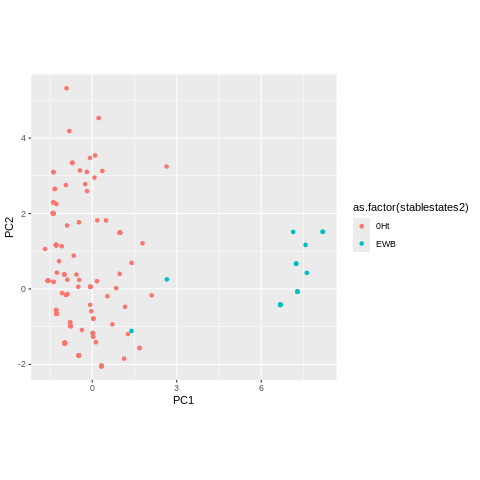

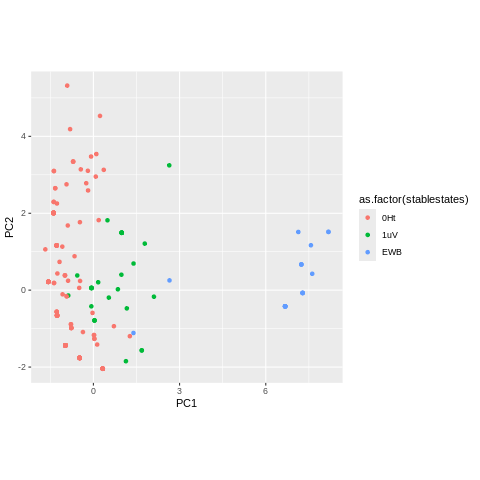

In [74]:
## PCplot
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
env <- gstbe[[4]][[sample.id]][[2]]
sa <- gstbe[[4]][[sample.id]][[3]]
ela <- gstbe[[4]][[sample.id]][[4]]
# if enmat=NULL, remove "[[sample.id]]"

PCplot(ocmat, sa, env, ssrep=ela[[2]])
PCplot(ocmat, sa, env, ssrep=ela[[2]], pruned=FALSE)

NULL


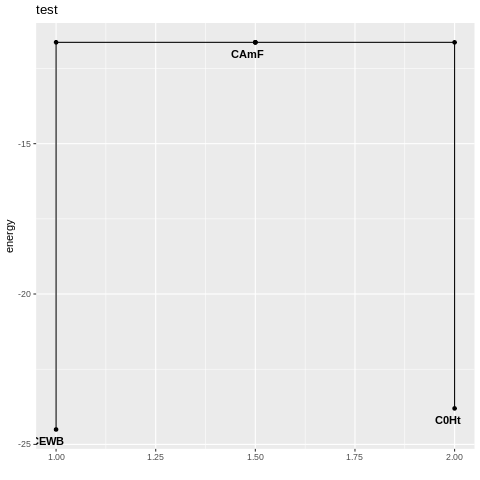

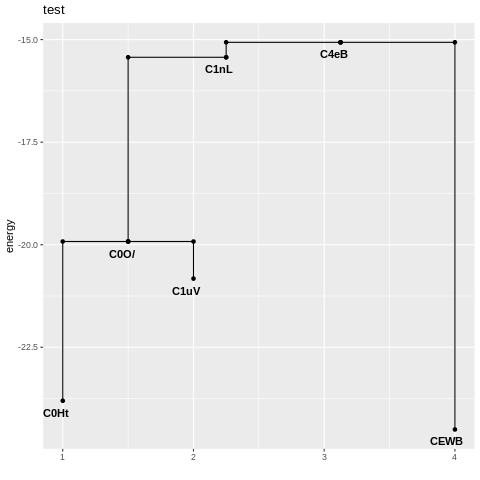

In [75]:
%%R
sample.id <- 1
ocmat <- gstbe[[4]][[sample.id]][[1]]
ela <- gstbe[[4]][[sample.id]][[4]]
elanp <- gstbe[[4]][[sample.id]][[5]]
# if enmat=NULL, remove "[[sample.id]]"

showDG(ela[[1]], ocmat, "test")
showDG(elanp, ocmat, "test")